# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [2]:
# pip install nltk scikit-learn matplotlib wordcloud

In [3]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [5]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [6]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [7]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# normalizujemy teksty na potrzeby dalszego przetwarzania


def preprocess_text(text: str) -> "list[str]":
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = re.sub(r'\s+', ' ', text)
    # usuwamy znaki interpunkcyjne
    text = re.sub(r'[' + punctuation + ']', '', text)
    # usuwamy wszystkie liczby
    text = re.sub(r'\d+', '', text)
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    # dzielimy na tokeny
    tokens = text.split()
    # usuwamy stopwords
    return [token for token in tokens if token not in STOPWORDS]

def stem_texts(corpus: "list[str]") -> "list[list[str]]":
    # stemmer = PorterStemmer()
    # stemmer = LancasterStemmer()
    # stemmer = SnowballStemmer('english')
    # stemmer = RSLPStemmer()
    stemmer = WordNetLemmatizer()
    return [[stemmer.lemmatize(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [9]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think really good team team really special good thing group close brian schmetzer


In [10]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus: "list[list[str]]") -> "list[str]":
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    return sorted(set([word for text in corpus for word in text]))

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

51874


In [11]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus: "list[list[str]]", wordlist: "list[str]") -> "dict[str, int]":
    # return {word -> count}
    doc_freq: defaultdict[str, int] = defaultdict(int)
    for text in corpus:
        for word in set(text):
            doc_freq[word] += 1
    return doc_freq


document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [12]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie


def get_term_frequencies(corpus: "list[list[str]]", news_ids: "list[str]") -> "dict[str, defaultdict[str, int]]":
    # return {news_id -> {word -> count}}
    term_freq: dict[str, defaultdict[str, int]] = {news_id: defaultdict(int) for news_id in news_ids}
    for news_id, text in zip(news_ids, corpus):
        for word in text:
            term_freq[news_id][word] += 1
    return term_freq


term_frequency = get_term_frequencies(stemmed_texts, news_ids)

In [13]:
# sprawdzmy wyniki
print(stemmed_texts[2])
term_frequency[news_ids[2]]

['think', 'really', 'good', 'team', 'team', 'really', 'special', 'good', 'thing', 'group', 'close', 'brian', 'schmetzer']


defaultdict(int,
            {'think': 1,
             'really': 2,
             'good': 2,
             'team': 2,
             'special': 1,
             'thing': 1,
             'group': 1,
             'close': 1,
             'brian': 1,
             'schmetzer': 1})

In [14]:
# obliczamy metryke tf_idf

def calculate_tf_idf(
        term_frequency: "dict[str, defaultdict[str, int]]", 
        document_frequency: "dict[str, int]", 
        corpus_size: int) -> "dict[str, dict[str, float]]":
    tf_idf: dict[str, dict[str, float]] = {news_id: {} for news_id in term_frequency.keys()}
    # return {news_id -> {word -> tf_idf}}
    for news_id in term_frequency.keys():
        for word in term_frequency[news_id].keys():
            tf = term_frequency[news_id][word]
            df = document_frequency[word]
            tf_idf[news_id][word] = tf * math.log(corpus_size / df)
    return tf_idf

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [15]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.5279304056467895,
 'really': 9.707261090572182,
 'good': 8.107747259335776,
 'team': 6.19845372520361,
 'special': 4.836281906951478,
 'thing': 4.111693200556713,
 'group': 4.2686255233458485,
 'close': 4.762876182017627,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [35]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

# METRIC = 'euclidean'
# METRIC = 'cosine'

def calculate_articles_distance(tf_idf: "dict[str, dict[str, float]]", id1: str, id2: str, metric: str='cosine') -> float:
    return calculate_vectors_distance(tf_idf[id1], tf_idf[id2], metric)

# helper function to calculate distance between two vectors in different metrics
def calculate_vectors_distance(vec1: "dict[str, float]", vec2: "dict[str, float]", metric: str='cosine') -> float:
    if metric == 'euclidean':
        return _euclidean_distance(vec1, vec2)
    if metric == 'cosine':
        return _cosine_similarity(vec1, vec2)
    raise ValueError(f'Unknown metric: {metric}')

def _euclidean_distance(vec1: "dict[str, float]", vec2: "dict[str, float]") -> float:
    if not vec1 or not vec2:
        return 0
    words = set(vec1.keys()) | set(vec2.keys())
    distance = 0
    for word in words:
        distance += (vec1.get(word, 0) - vec2.get(word, 0)) ** 2
    return math.sqrt(distance) / len(words)

def _cosine_similarity(vec1: "dict[str, float]", vec2: "dict[str, float]") -> float:
    if not vec1 or not vec2:
        return 0
    words = set(vec1.keys()) | set(vec2.keys())
    dot_product = 0
    norm1 = 0
    norm2 = 0
    for word in words:
        dot_product += vec1.get(word, 0) * vec2.get(word, 0)
        norm1 += vec1.get(word, 0) ** 2
        norm2 += vec2.get(word, 0) ** 2
    return dot_product / (math.sqrt(norm1) * math.sqrt(norm2))

calculate_articles_distance(tf_idf, news_ids[2], news_ids[1])

0.022309633608028356

In [17]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [ ]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf: "dict[str, dict[str, float]]", n_id: str, k: int) -> "list[str]":
    distances = [(calculate_articles_distance(tf_idf, n_id, id), id) for id in news_ids if id != n_id]
    recommendations = sorted(distances, key=lambda x: x[0], reverse=True)
    return [x[1] for x in recommendations[:k]]

def print_k_most_similar_news(tf_idf: "dict[str, dict[str, float]]", n_id: str, k: int, corpus: "dict[str, dict[str, str]]"):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 10, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [45]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(vectors: "list[dict[str, float]]") -> "dict[str, float]":
    words_union: set[str] = set().union(*[set(vec.keys()) for vec in vectors])
    return {word: sum([tf_idf[n_id].get(word, 0) for n_id in news_ids]) / len(news_ids) for word in words_union}

def calculate_user_average_vector(tf_idf: "dict[str, dict[str, float]]", news_ids: "list[str]") -> "dict[str, float]":
    words_union: set[str] = set().union(*[set(tf_idf[n_id]) for n_id in news_ids])
    return {word: sum([tf_idf[n_id].get(word, 0) for n_id in news_ids]) / len(news_ids) for word in words_union}

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf: "dict[str, dict[str, float]]", users_history: "dict[str, list[str]]") -> "dict[str, dict[str, float]]":
    return {u_id: calculate_user_average_vector(tf_idf, history) for u_id, history in users_history.items()}

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [46]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.3519562371795322), ('plane', 1.1701285777724966), ('diaz', 0.9848359105446637), ('paula', 0.8214687066477994), ('acre', 0.8090445060145697), ('ventura', 0.7780260164933531), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailstone', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.7003279596096246), ('landing', 0.6898259834067665), ('chaser', 0.6756286236624416), ('ditching', 0.6466668302261441), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('twoweek', 0.6177050367898467), ('airline', 0.61297833353473), ('consuming', 0.6033714156854073), ('storyful', 0.6009271210247275), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('containment', 0.5476458044318663), ('may', 0.5474399003934919), ('large', 0.5466527040626348), ('according', 0.5448385719446568), ('filming', 0.5447299476804195), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('gaming', 0.5248991093519709), ('mandatory', 0.5227667548412794

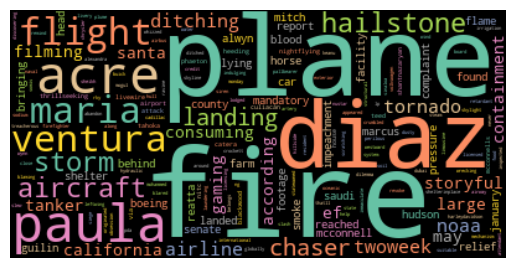

In [28]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

In [51]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal
USER_ID = 1

def print_recommendations(recommendations, news):
    for i, (dist, n_id) in enumerate(recommendations, 1):
        print(f'{i}. [{dist:.4f}] {news[n_id]}')

def recommend(tf_idf, user_id, news, users_history, k, metric='cosine'):
    user_vector = user_vectors[user_id]
    distances = [(calculate_vectors_distance(tf_idf[n_id], user_vector, metric), n_id) for n_id in news_ids if n_id not in users_history[user_id]]
    recommendations = sorted(distances, key=lambda x: x[0], reverse=True)
    return recommendations[:k]

User history:
1. {'news_id': 'N24422', 'category': 'sports', 'subcategory': 'football_nfl', 'title': 'Lamar Jackson makes NFL history with huge day in win over Bengals', 'abstract': ''}
2. {'news_id': 'N25287', 'category': 'sports', 'subcategory': 'basketball_nba', 'title': "Steve Kerr: Steph Curry is 'at his peak physically, mentally'", 'abstract': ''}
3. {'news_id': 'N39121', 'category': 'sports', 'subcategory': 'basketball_nba', 'title': 'Celtics, Zion remain sizzling to start preseason', 'abstract': "Preseason numbers often mean almost nothing. Rotations are unusual, starters rarely play much, and few if any teams are putting a premium on winning games. As such, it's tough to glean much from exhibition stats. But what the Boston Celtics and New Orleans rookie Zion Williamson   the No. 1 pick in this year's draft   have been doing so far in the preseason certainly stands out. The Celtics are 3-0 after beating Cleveland on Sunday   and have..."}
4. {'news_id': 'N41777', 'category': '

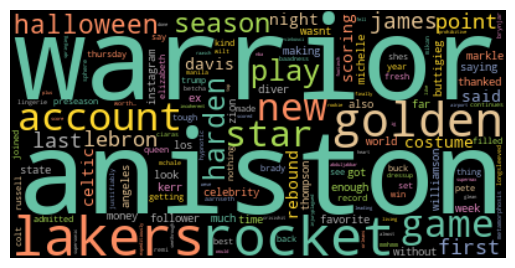


Recommendations:
1. [0.2256] {'news_id': 'N25062', 'category': 'sports', 'subcategory': 'basketball_nba', 'title': 'James Harden scores 36 points, Rockets rout Warriors 129-112', 'abstract': 'HOUSTON (AP)   James Harden had 36 points and 13 assists and the Houston Rockets routed Golden State 129-112 on Wednesday night, sending the short-handed Warriors to their sixth loss in eight games this season. Harden again appeared to be moving past his early shooting woes, going 6 of 16 from 3-point range. Since going 17 of 79 on 3s in his first six games, Harden has made 13 of 32 the last two. Russell Westbrook had 18 points, eight rebounds...'}
2. [0.2206] {'news_id': 'N24105', 'category': 'sports', 'subcategory': 'basketball_nba', 'title': "Rockets' James Harden named NBA West's Player of the Week", 'abstract': 'NEW ORLEANS   Rockets guard James Harden on Monday was named the Western Conference Player of the Week, the 23rd time he has taken the honor during his eight seasons with the Rockets

In [52]:
# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje
print('User history:')
for i, n_id in enumerate(users_history[test_users[USER_ID]], 1):
    print(f'{i}. {news[n_id]}')

print('\nUser profile:')
plot_vector(user_vectors[test_users[USER_ID]])

recs = recommend(tf_idf, test_users[USER_ID], news, users_history, 10)
print('\nRecommendations:')
print_recommendations(recs, news)

## Część 6. - Ocena jakości

In [43]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1: "dict[str, float]", v2: "dict[str, float]"):
    words = set(v1.keys()) | set(v2.keys())
    intersection = sum(min(v1.get(word, 0), v2.get(word, 0)) for word in words)
    union = sum(max(v1.get(word, 0), v2.get(word, 0)) for word in words)
    return intersection / union


In [ ]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

K = 5, 10, 20
METRICS = 'euclidean', 'cosine'

def get_users_recommendations(max_k: int):
    # return {user_id -> {metric -> recommendations[:max_k]}}
    return {user_id: {metric: recommend(tf_idf, user_id, news, users_history, max_k, metric) for metric in METRICS} for user_id in test_users}


users_recommendations = get_users_recommendations(max(K))

In [62]:
from tabulate import tabulate

class TestEntry():
    def __init__(self, user: str, k: int, metric: str, jaccard: float):
        self.user = user
        self.k = k
        self.metric = metric
        self.jaccard = jaccard
    
    def tuple(self):
        return (self.user, self.k, self.metric, self.jaccard)

def print_test_results(entries: "list[TestEntry]"):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('user', 'k', 'metric', 'jaccard')
    print(tabulate(data, headers, tablefmt='github'))


In [64]:
def test_user_recommendations(users_recommendations, user_id: str, k: int, metric: str):
    user_recs = users_recommendations[user_id][metric][:k]
    user_vector = user_vectors[user_id]
    recs_vector = calculate_average_vector([tf_idf[n_id] for _, n_id in user_recs])
    return jaccard(user_vector, recs_vector)

def get_test_entries(users_recommendations):
    entries = []
    for user_id in test_users:
        for k in K:
            for metric in METRICS:
                jaccard_index = test_user_recommendations(users_recommendations, user_id, k, metric)
                entries.append(TestEntry(user_id, k, metric, jaccard_index))
    return entries


test_entries = get_test_entries(users_recommendations)
print_test_results(test_entries)

| user   |   k | metric    |   jaccard |
|--------|-----|-----------|-----------|
| U10045 |   5 | euclidean | 0.0501639 |
| U10045 |   5 | cosine    | 0.0301689 |
| U10045 |  10 | euclidean | 0.0791362 |
| U10045 |  10 | cosine    | 0.0369501 |
| U10045 |  20 | euclidean | 0.104489  |
| U10045 |  20 | cosine    | 0.0573402 |
| U53231 |   5 | euclidean | 0.0249154 |
| U53231 |   5 | cosine    | 0.0346631 |
| U53231 |  10 | euclidean | 0.0513899 |
| U53231 |  10 | cosine    | 0.0449503 |
| U53231 |  20 | euclidean | 0.0632512 |
| U53231 |  20 | cosine    | 0.0549752 |
| U70879 |   5 | euclidean | 0.084729  |
| U70879 |   5 | cosine    | 0.0220953 |
| U70879 |  10 | euclidean | 0.121956  |
| U70879 |  10 | cosine    | 0.0440265 |
| U70879 |  20 | euclidean | 0.147327  |
| U70879 |  20 | cosine    | 0.0798391 |
| U89744 |   5 | euclidean | 0.0751743 |
| U89744 |   5 | cosine    | 0.0552236 |
| U89744 |  10 | euclidean | 0.112862  |
| U89744 |  10 | cosine    | 0.0679997 |
| U89744 |  20 |

In [65]:
avg_euclidean = sum(e.jaccard for e in test_entries if e.metric == 'euclidean') / len(test_entries)
avg_cosine = sum(e.jaccard for e in test_entries if e.metric == 'cosine') / len(test_entries)
print(f'Average Jaccard index for Euclidean metric: {avg_euclidean:.4f}')
print(f'Average Jaccard index for Cosine metric: {avg_cosine:.4f}')

print(f'The winner is: {"Euclidean" if avg_euclidean > avg_cosine else "Cosine"} metric!')

Average Jaccard index for Euclidean metric: 0.0448
Average Jaccard index for Cosine metric: 0.0243
The winner is: Euclidean metric!
